<a href="https://colab.research.google.com/github/datafriends/Workshops/blob/master/How_to_hack_a_hack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to hack a Hack with R

## 1. Specify the problem

Context: 
- In Australia a Credit License enables you to credit to others. 
- A Financial Services license is about providing guidance to people buying financial products. You can't engage in credit activities with a FSL.


Prompt: 
- Has the regulatory scrutiny in Australia recently led to a change in distribution of
credit licenses vs financial services licenses? 
- Is there evidence that greater scruitany in banking is resulting in fewer Credit Licenses and more Financial Services Licenses?

## 2. Investigate the dataset

In [2]:
# load some libraries we will need
library(tidyverse)
library(lubridate)


options(repr.plot.width=6, repr.plot.height=4)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  2.1.1     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



In [3]:
install.packages("shiny")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘later’, ‘promises’



In [0]:
library(shiny)

In [0]:
# download datasets from data.gov.au

# FSL dataset
afs_file <- "https://data.gov.au/data/dataset/ab7eddce-84df-4098-bc8f-500d0d9776d1/resource/1fc2b334-74ae-4588-85aa-83e3a8c9f2cc/download/afs_lic_201906.tsv"

In [0]:
afs <- read.table(afs_file, sep = '\t', header = TRUE, comment.char="",  quote ="\"")



In [0]:
# credit dataset
credit_file <- "https://data.gov.au/data/dataset/fa0b0d71-b8b8-4af8-bc59-0b000ce0d5e4/resource/3abf1383-c4e5-4c1a-8331-8434b17b6f10/download/credit_lic_201906.tsv"


In [0]:
# YOUR TURN: read in the credit license file: call it "credit" in this cell.

In [11]:
tail(afs, 10)

,REGISTER_NAME,AFS_LIC_NUM,AFS_LIC_NAME,AFS_LIC_ABN_ACN,AFS_LIC_START_DT,AFS_LIC_PRE_FSR,AFS_LIC_ADD_LOCAL,AFS_LIC_ADD_STATE,AFS_LIC_ADD_PCODE,AFS_LIC_ADD_COUNTRY,AFS_LIC_LAT,AFS_LIC_LNG,AFS_LIC_CONDITION
,<fct>,<int>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dbl>,<fct>
6221,AFS Licence,434976,TOTAL GAS & POWER ASIA PRIVATE LIMITED,71161771286,20130417,,,,0,International,NA,NA,"This licence authorises the licensee to carry on a financial services business to:~provide financial product advice for the following classes of financial products:~derivatives;~Australian carbon credit units; and~eligible international emissions units; and~deal in a financial product by:~issuing, applying for, acquiring, varying or disposing of a financial product in respect of the following classes of financial products:~derivatives; and~applying for, acquiring, varying or disposing of a financial product on behalf of another person in respect of the following classes of products:~derivatives;~Australian carbon credit units; and~eligible international emissions units;~to wholesale clients."
6222,AFS Licence,435101,MIC RISK SOLUTIONS CO. LTD.,165758832,20130522,,,,0,International,NA,NA,"This licence authorises the licensee to carry on a financial services business to:~provide general financial product advice only, for the following classes of financial products:~general insurance products ;~to wholesale clients."
6223,AFS Licence,438157,DAVANTAGE GROUP PTY LTD,35161967166,20130604,,TRARALGON,VIC,3844,Australia,-38.22213,146.5211,"This licence authorises the licensee to carry on a financial services business to:~provide general financial product advice for the following classes of financial products:~financial products limited to:~miscellaneous financial risk products limited to extended warranty products and motor vehicle gap cover products; and~deal in a financial product by:~issuing, applying for, acquiring, varying or disposing of a financial product in respect of the following classes of financial products:~financial products limited to:~miscellaneous financial risk products limited to extended warranty products and motor vehicle gap cover products; and~applying for, acquiring, varying or disposing of a financial product on behalf of another person in respect of the following classes of products:~financial products limited to:~miscellaneous financial risk products limited to extended warranty products and motor vehicle gap cover products;~to retail and wholesale clients."
6224,AFS Licence,441376,ENETT INTERNATIONAL (SINGAPORE) PTE. LTD.,161362661,20131114,,,,0,International,NA,NA,"This licence authorises the licensee to carry on a financial services business to:~deal in a financial product by:~issuing, applying for, acquiring, varying or disposing of a financial product in respect of the following classes of financial products:~deposit and payment products limited to:~non-cash payment products; and~applying for, acquiring, varying or disposing of a financial product on behalf of another person in respect of the following classes of products:~deposit and payment products limited to:~non-cash payment products;~to retail and wholesale clients."
6225,AFS Licence,444649,ADVANCED MARKETS LTD.,164968549,20131211,,,,0,International,NA,NA,"This licence authorises the licensee to carry on a financial services business to:~provide financial product advice for the following classes of financial products:~derivatives; and~foreign exchange contracts;~deal in a financial product by:~issuing, applying for, acquiring, varying or disposing of a financial product in respect of the following classes of financial products:~derivatives; and~foreign exchange contracts; and~make a market for the following financial products:~foreign exchange contracts; and~derivatives;~to wholesale clients."
6226,AFS Licence,467056,RD LEGAL CAPITAL LLC,601248980,20150204,,,,0,International,NA,NA,"This licence authorises the licensee to carry on a financial services business t

In [0]:
# MY SOLUTION: Ok, this was an easy one!
credit <- read.table(credit_file, sep = '\t', header = TRUE, comment.char="",  quote ="\"")

In [13]:
tail(credit, 10)

,REGISTER_NAME,CRED_LIC_NUM,CRED_LIC_NAME,CRED_LIC_START_DT,CRED_LIC_END_DT,CRED_LIC_STATUS,CRED_LIC_ABN_ACN,CRED_LIC_AFSL_NUM,CRED_LIC_STATUS_HISTORY,CRED_LIC_LOCALITY,CRED_LIC_STATE,CRED_LIC_PCODE,CRED_LIC_LAT,CRED_LIC_LNG,CRED_LIC_EDRS,CRED_LIC_BN,CRED_LIC_AUTHORISATIONS
,<fct>,<int>,<fct>,<fct>,<lgl>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<fct>,<fct>,<fct>
5234,Credit Licence,514614,"LEE, JONG SHIN",18/04/2019,NA,APPR,55205899744,0,,BOULEVARDE STRATHFIELD,NSW,2135,-33.88017,151.0928,AFCA,,This licence authorises the licensee to:~Engage in credit activities other than as a credit provider by:~providing a credit service where the licensee is not or will not be:~where the service relates to a credit contract or proposed credit contract - the credit provider under the contract; or~where the service relates to a consumer lease or proposed consumer lease - the lessor; and/or~performing the obligations or exercising the rights of a credit provider in relation to a credit contract or proposed credit contract under which the licensee is not or will not be the credit provider; and/or~performing the obligations or exercising the rights of a mortgagee in relation to a mortgage or proposed mortgage that secures or will secure obligations under a credit contract under which the licensee is not the credit provider; and/or~performing the obligations or exercising the rights of a beneficiary under a guarantee or proposed guarantee that guarantees obligations under a credit contract under which the licensee is not the credit provider; and/or~performing the obligations or exercising the rights of a lessor in relation to a consumer lease or proposed consumer lease where the licensee is not or will not be the lessor
5235,Credit Licence,514650,LOAN IQ PTY. LTD.,04/04/2019,NA,APPR,80608270435,0,,BEECROFT,NSW,2119,-33.75674,151.0719,AFCA,,This licence authorises the licensee to:~Engage in credit activities other than as a credit provider by:~providing a credit service where the licensee is not or will not be:~where the service relates to a credit contract or proposed credit contract - the credit provider under the contract; or~where the service relates to a consumer lease or proposed consumer lease - the lessor; and/or~performing the obligations or exercising the rights of a credit provider in relation to a credit contract or proposed credit contract under which the licensee is not or will not be the credit provider; and/or~performing the obligations or exercising the rights of a mortgagee in relation to a mortgage or proposed mortgage that secures or will secure obligations under a credit contract under which the licensee is not the credit provider; and/or~performing the obligations or exercising the rights of a beneficiary under a guarantee or proposed guarantee that guarantees obligations under a credit contract under which the licensee is not the credit provider; and/or~performing the obligations or exercising the rights of a lessor in relation to a consumer lease or proposed consumer lease where the licensee is not or will not be the lessor
5236,Credit Licence,514759,DPN PTY LTD,14/05/2019,NA,APPR,94630700186,0,,CRONULLA,NSW,2230,-33.96954,151.1168,AFCA,,This licence authorises the licensee to:~Engage in credit activities other than as a credit provider by:~providing a credit service where the licensee is not or will not be:~where the service relates to a credit contract or proposed credit contract - the credit provider under the contract; or~where the service relates to a consumer lease or proposed consumer lease - the lessor; and/or~performing the obligations or exercising the rights of a credit provider in relation to a credit contract or proposed credit contract under which the licensee is not or will not be the credit provider; and/or~performing the obligations or exercising the rights of a mortgagee in relation to a mortgage or proposed mortgage that secures or will secure obligations under a credit contract under which 

We can find out some basic information about our datasets. I'll do the afs data, you guys jump in and tell me about the credit data.

In [14]:
str(afs)

'data.frame':	6230 obs. of  13 variables:
 $ REGISTER_NAME      : Factor w/ 1 level "AFS Licence": 1 1 1 1 1 1 1 1 1 1 ...
 $ AFS_LIC_NUM        : int  218585 218600 218678 218705 218770 219140 219195 219326 219431 219462 ...
 $ AFS_LIC_NAME       : Factor w/ 6230 levels "100 DOORS PTY. LTD.",..: 5548 3005 2882 5538 2432 2681 2687 5710 4177 4391 ...
 $ AFS_LIC_ABN_ACN    : num  7.61e+10 8.50e+10 8.91e+10 7.41e+10 8.01e+10 ...
 $ AFS_LIC_START_DT   : Factor w/ 2735 levels "01/01/2003","01/01/2004",..: 915 127 2291 1954 1986 1116 2699 964 313 399 ...
 $ AFS_LIC_PRE_FSR    : Factor w/ 1343 levels "","FutAdv 062399",..: 353 208 1 1 20 1 471 1 1 791 ...
 $ AFS_LIC_ADD_LOCAL  : Factor w/ 1030 levels "","ABBOTSFORD",..: 847 844 888 595 888 888 702 687 839 888 ...
 $ AFS_LIC_ADD_STATE  : Factor w/ 9 levels "","ACT","NSW",..: 5 8 3 8 3 3 6 9 8 3 ...
 $ AFS_LIC_ADD_PCODE  : int  4000 3006 2000 3000 2000 2000 5067 6159 3205 2000 ...
 $ AFS_LIC_ADD_COUNTRY: Factor w/ 2 levels "Australia","Internat

In [15]:
summary(afs)

     REGISTER_NAME   AFS_LIC_NUM    
 AFS Licence:6230   Min.   :218585  
                    1st Qu.:246488  
                    Median :344217  
                    Mean   :363804  
                    3rd Qu.:480936  
                    Max.   :515139  
                                    
                                    AFS_LIC_NAME  AFS_LIC_ABN_ACN    
 100 DOORS PTY. LTD.                      :   1   Min.   :0.000e+00  
 101 CAPITAL PTY LTD                      :   1   1st Qu.:3.001e+10  
 123 INVESTMENT MANAGEMENT PTY LTD        :   1   Median :5.212e+10  
 151 PROPERTY CORE PLUS MANAGEMENT LIMITED:   1   Mean   :5.221e+10  
 1868 CAPITAL PTY LIMITED                 :   1   3rd Qu.:7.607e+10  
 1KW ADELAIDE PTY LTD                     :   1   Max.   :9.968e+10  
 (Other)                                  :6224                      
   AFS_LIC_START_DT
 01/03/2004: 209   
 10/03/2004: 192   
 01/01/2004:  83   
 01/02/2004:  83   
 01/12/2003:  67   
 01/07/2003:  34   
 (Ot

In [0]:
# YOUR TURN: credit dataset investigation:

# 1. investigate the credit dataset.

# 2. How do we change the names of the credit and the afs datasets so they have common names? 

## 3. Data Wrangling

We need to drop the AFS_ prefix from the afs dataset and the CRED_prefix from the credit dataset variables.

In [16]:
head(afs,1)

REGISTER_NAME,AFS_LIC_NUM,AFS_LIC_NAME,AFS_LIC_ABN_ACN,AFS_LIC_START_DT,AFS_LIC_PRE_FSR,AFS_LIC_ADD_LOCAL,AFS_LIC_ADD_STATE,AFS_LIC_ADD_PCODE,AFS_LIC_ADD_COUNTRY,AFS_LIC_LAT,AFS_LIC_LNG,AFS_LIC_CONDITION
<fct>,<int>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dbl>,<fct>
AFS Licence,218585,TERRI SCHEER INSURANCE PTY LTD,76070874798,11/03/2002,InsGen 50160,SPRING HILL,QLD,4000,Australia,-27.45846,153.0225,"This licence authorises the licensee to carry on a financial services business to:~provide financial product advice for the following classes of financial products:~general insurance products; and~deal in a financial product by:~issuing, applying for, acquiring, varying or disposing of a financial product in respect of the following classes of financial products:~general insurance products; and~applying for, acquiring, varying or disposing of a financial product on behalf of another person in respect of the following classes of products:~general insurance products;~to retail and wholesale clients."


In [17]:
head(credit,1)

REGISTER_NAME,CRED_LIC_NUM,CRED_LIC_NAME,CRED_LIC_START_DT,CRED_LIC_END_DT,CRED_LIC_STATUS,CRED_LIC_ABN_ACN,CRED_LIC_AFSL_NUM,CRED_LIC_STATUS_HISTORY,CRED_LIC_LOCALITY,CRED_LIC_STATE,CRED_LIC_PCODE,CRED_LIC_LAT,CRED_LIC_LNG,CRED_LIC_EDRS,CRED_LIC_BN,CRED_LIC_AUTHORISATIONS
<fct>,<int>,<fct>,<fct>,<lgl>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<fct>,<fct>,<fct>
Credit Licence,219612,GIPPSREAL LIMITED,04/10/2010,NA,APPR,80005443292,219612,,LEONGATHA,VIC,3953,-38.17622,146.3011,FOS,,This licence authorises the licensee to:~Engage in credit activities as a credit provider by:~carrying on a business of providing credit being credit the provision of which the National Credit Code applies to; and/or~being a credit provider under a credit contract; and/or~performing the obligations or exercising the rights of a credit provider in relation to a credit contract or proposed credit contract as the credit provider; and/or~providing credit assistance to a consumer which relates to a credit contract or proposed credit contract under which the licensee is or will be the credit provider; and/or~being a mortgagee under a mortgage that secures or will secure obligations under a credit contract under which the licensee is the credit provider; and/or~performing the obligations or exercising the rights of a mortgagee in relation to a mortgage or proposed mortgage which secures or will secure obligations under a credit contract under which the licensee is the credit provider; and/or~being a beneficiary under a guarantee that guarantees obligations under a credit contract under which the licensee is the credit provider; and/or~performing the obligations or exercising the rights of a beneficiary under a guarantee or proposed guarantee which guarantees obligations under a credit contract under which the licensee is the credit provider; and/or~carrying on a business of providing consumer leases; and/or~being a lessor under a consumer lease; and/or~providing credit assistance to a consumer in relation to a consumer lease or proposed consumer lease for which the licensee is the lessor; and/or~performing the obligations or exercising the rights of a lessor in relation to the consumer lease as the lessor


In [18]:
names(afs)
names(credit)

[1] "REGISTER_NAME"       "AFS_LIC_NUM"         "AFS_LIC_NAME"       
 [4] "AFS_LIC_ABN_ACN"     "AFS_LIC_START_DT"    "AFS_LIC_PRE_FSR"    
 [7] "AFS_LIC_ADD_LOCAL"   "AFS_LIC_ADD_STATE"   "AFS_LIC_ADD_PCODE"  
[10] "AFS_LIC_ADD_COUNTRY" "AFS_LIC_LAT"         "AFS_LIC_LNG"        
[13] "AFS_LIC_CONDITION"

[1] "REGISTER_NAME"           "CRED_LIC_NUM"           
 [3] "CRED_LIC_NAME"           "CRED_LIC_START_DT"      
 [5] "CRED_LIC_END_DT"         "CRED_LIC_STATUS"        
 [7] "CRED_LIC_ABN_ACN"        "CRED_LIC_AFSL_NUM"      
 [9] "CRED_LIC_STATUS_HISTORY" "CRED_LIC_LOCALITY"      
[11] "CRED_LIC_STATE"          "CRED_LIC_PCODE"         
[13] "CRED_LIC_LAT"            "CRED_LIC_LNG"           
[15] "CRED_LIC_EDRS"           "CRED_LIC_BN"            
[17] "CRED_LIC_AUTHORISATIONS"

In [0]:
# I'll clean the afs dataset, below you can clean the credit dataset

rename_cols <- function(prefix, dataset) {
  gsub(prefix, "", names(dataset))
}


In [0]:
# remove the AFS_ prefix
names(afs) <- rename_cols("AFS_", afs)

# oops there is also a random ADD_ which needs to be removed in names like AFS_LIC_ADD_LOCAL
names(afs) <- rename_cols("ADD_", afs)
names(afs)[names(afs) == "LIC_LOCAL"] <-"LIC_LOCALITY"

In [21]:
# YOUR TURN: drop the _CRED prefix from the credit file

names(credit)

[1] "REGISTER_NAME"           "CRED_LIC_NUM"           
 [3] "CRED_LIC_NAME"           "CRED_LIC_START_DT"      
 [5] "CRED_LIC_END_DT"         "CRED_LIC_STATUS"        
 [7] "CRED_LIC_ABN_ACN"        "CRED_LIC_AFSL_NUM"      
 [9] "CRED_LIC_STATUS_HISTORY" "CRED_LIC_LOCALITY"      
[11] "CRED_LIC_STATE"          "CRED_LIC_PCODE"         
[13] "CRED_LIC_LAT"            "CRED_LIC_LNG"           
[15] "CRED_LIC_EDRS"           "CRED_LIC_BN"            
[17] "CRED_LIC_AUTHORISATIONS"

In [22]:
names(afs)

[1] "REGISTER_NAME" "LIC_NUM"       "LIC_NAME"      "LIC_ABN_ACN"  
 [5] "LIC_START_DT"  "LIC_PRE_FSR"   "LIC_LOCALITY"  "LIC_STATE"    
 [9] "LIC_PCODE"     "LIC_COUNTRY"   "LIC_LAT"       "LIC_LNG"      
[13] "LIC_CONDITION"

In [0]:
# MY SOLUTION: drop the _CRED prefix from the credit file

names(credit) <- rename_cols("CRED_", credit)

In [24]:
names(credit)

[1] "REGISTER_NAME"      "LIC_NUM"            "LIC_NAME"          
 [4] "LIC_START_DT"       "LIC_END_DT"         "LIC_STATUS"        
 [7] "LIC_ABN_ACN"        "LIC_AFSL_NUM"       "LIC_STATUS_HISTORY"
[10] "LIC_LOCALITY"       "LIC_STATE"          "LIC_PCODE"         
[13] "LIC_LAT"            "LIC_LNG"            "LIC_EDRS"          
[16] "LIC_BN"             "LIC_AUTHORISATIONS"

In [0]:
# keep the common variables

common_names <- names(afs)[names(afs) %in% names(credit)]

afs <- select(afs, common_names)


In [0]:
# YOUR TURN: select the common_names in the credit dataset

In [26]:
names(afs)

[1] "REGISTER_NAME" "LIC_NUM"       "LIC_NAME"      "LIC_ABN_ACN"  
 [5] "LIC_START_DT"  "LIC_LOCALITY"  "LIC_STATE"     "LIC_PCODE"    
 [9] "LIC_LAT"       "LIC_LNG"

In [27]:
names(credit)

[1] "REGISTER_NAME"      "LIC_NUM"            "LIC_NAME"          
 [4] "LIC_START_DT"       "LIC_END_DT"         "LIC_STATUS"        
 [7] "LIC_ABN_ACN"        "LIC_AFSL_NUM"       "LIC_STATUS_HISTORY"
[10] "LIC_LOCALITY"       "LIC_STATE"          "LIC_PCODE"         
[13] "LIC_LAT"            "LIC_LNG"            "LIC_EDRS"          
[16] "LIC_BN"             "LIC_AUTHORISATIONS"

In [0]:
# MY SOLUTION: select the common_names in the credit dataset
credit <- select(credit, common_names)

In [29]:
# create a combined dataset

dat <- bind_rows(afs, credit)

str(dat)

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning mess

'data.frame':	11473 obs. of  10 variables:
 $ REGISTER_NAME: chr  "AFS Licence" "AFS Licence" "AFS Licence" "AFS Licence" ...
 $ LIC_NUM      : int  218585 218600 218678 218705 218770 219140 219195 219326 219431 219462 ...
 $ LIC_NAME     : chr  "TERRI SCHEER INSURANCE PTY LTD" "INTERPACIFIC INSURANCE BROKERS PTY. LTD." "IMC PACIFIC PTY LTD" "TELSTRA SUPER FINANCIAL PLANNING PTY LTD" ...
 $ LIC_ABN_ACN  : num  7.61e+10 8.50e+10 8.91e+10 7.41e+10 8.01e+10 ...
 $ LIC_START_DT : chr  "11/03/2002" "02/05/2002" "26/04/2002" "22/04/2002" ...
 $ LIC_LOCALITY : chr  "SPRING HILL" "SOUTHBANK" "SYDNEY" "MELBOURNE" ...
 $ LIC_STATE    : Factor w/ 9 levels "","ACT","NSW",..: 5 8 3 8 3 3 6 9 8 3 ...
 $ LIC_PCODE    : int  4000 3006 2000 3000 2000 2000 5067 6159 3205 2000 ...
 $ LIC_LAT      : num  -27.5 -37.8 -33.9 -38 -33.9 ...
 $ LIC_LNG      : num  153 145 151 145 151 ...


In [30]:
# we need to change the Start_Date to date format

dat <- mutate(dat, LIC_START_DT = dmy(LIC_START_DT))

str(dat)

Warning message:
“ 10 failed to parse.”

'data.frame':	11473 obs. of  10 variables:
 $ REGISTER_NAME: chr  "AFS Licence" "AFS Licence" "AFS Licence" "AFS Licence" ...
 $ LIC_NUM      : int  218585 218600 218678 218705 218770 219140 219195 219326 219431 219462 ...
 $ LIC_NAME     : chr  "TERRI SCHEER INSURANCE PTY LTD" "INTERPACIFIC INSURANCE BROKERS PTY. LTD." "IMC PACIFIC PTY LTD" "TELSTRA SUPER FINANCIAL PLANNING PTY LTD" ...
 $ LIC_ABN_ACN  : num  7.61e+10 8.50e+10 8.91e+10 7.41e+10 8.01e+10 ...
 $ LIC_START_DT : Date, format: "2002-03-11" "2002-05-02" ...
 $ LIC_LOCALITY : chr  "SPRING HILL" "SOUTHBANK" "SYDNEY" "MELBOURNE" ...
 $ LIC_STATE    : Factor w/ 9 levels "","ACT","NSW",..: 5 8 3 8 3 3 6 9 8 3 ...
 $ LIC_PCODE    : int  4000 3006 2000 3000 2000 2000 5067 6159 3205 2000 ...
 $ LIC_LAT      : num  -27.5 -37.8 -33.9 -38 -33.9 ...
 $ LIC_LNG      : num  153 145 151 145 151 ...


## 4. Exploratory Data Analysis

In [0]:
summary_data <- select(dat, REGISTER_NAME, LIC_NUM, LIC_START_DT) %>% # variables we wish to keep
                    mutate(year = year(LIC_START_DT), # the year part of LIC_START_DATE
                           mon = sprintf("%02d", month(LIC_START_DT))) %>% # the month part of LIC_START_DATE
                    group_by(year, mon, REGISTER_NAME) %>% # roll up the data by year and month and license type
                    summarise(cnt = n()) %>% # count the rows
                    filter(year >= 2000) # subset for the data after 2000

In [32]:
summary_data

year,mon,REGISTER_NAME,cnt
<dbl>,<chr>,<chr>,<int>
2002,03,AFS Licence,1
2002,04,AFS Licence,2
2002,05,AFS Licence,3
2002,06,AFS Licence,9
2002,07,AFS Licence,11
2002,08,AFS Licence,19
2002,09,AFS Licence,15
2002,10,AFS Licence,17
2002,11,AFS Licence,15


In [33]:
# YOUR TURN: run the following code, what is the problem with the data before year 2000?
temp_data <- select(dat, REGISTER_NAME, LIC_NUM, LIC_START_DT) %>% # variables we wish to keep
                    mutate(year = year(LIC_START_DT)) %>% # the year part of LIC_START_DATE
                    group_by(year, REGISTER_NAME) %>% # roll up the data by year and month and license type
                    summarise(cnt = n())

temp_data

year,REGISTER_NAME,cnt
<dbl>,<chr>,<int>
201,AFS Licence,1
204,AFS Licence,1
209,AFS Licence,1
217,AFS Licence,1
222,AFS Licence,1
225,AFS Licence,1
305,AFS Licence,1
310,AFS Licence,1
403,AFS Licence,1


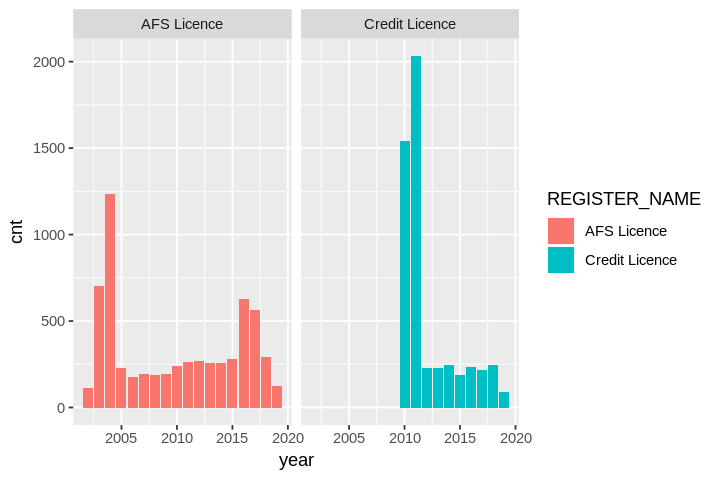

In [34]:
# we can plot the data like this, what do you notice in this plot?:

ggplot(data = summary_data, aes(year, cnt)) + # pass in the dataset and the variables year and count
    geom_bar(stat = "identity", aes(fill = REGISTER_NAME)) + # do a bar plot, but color by license type
    facet_wrap(REGISTER_NAME ~ .) # facet the data to produce 2 graphs for each license type.


In [35]:
# YOUR TURN: can you create the summary data again, but this time filter for year >= 2012

# extra marks if you can reproduce this plot above but this time facet by state LIC_STATE?

table(summary_data$year)

table(temp_data$year)


2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 
  10   12   12   12   12   12   12   12   18   24   24   24   24   24   24   24 
2018 2019 
  24   12 


 201  204  209  217  222  225  305  310  403  611  701  706  804 1006 1008 1012 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
1027 1106 1109 1117 1124 1125 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    2    2 
2012 2013 2014 2015 2016 2017 2018 2019 
   2    2    2    2    2    2    2    2 

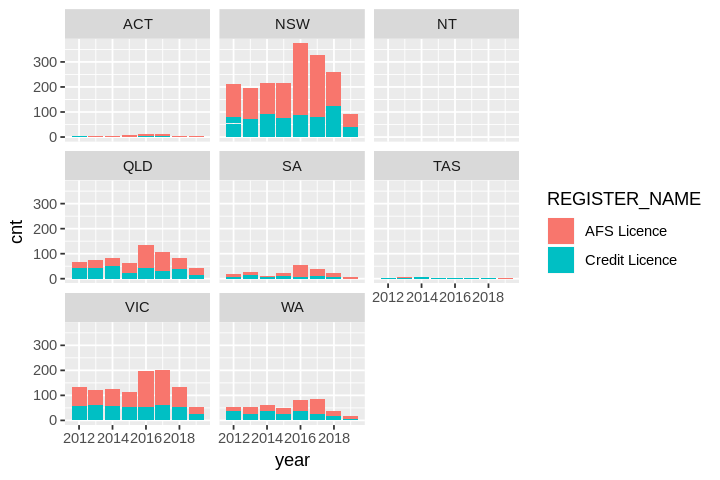

In [36]:
# MY SOLUTION

summary_data <- select(dat, REGISTER_NAME, LIC_NUM, LIC_STATE, LIC_START_DT) %>%
    mutate(year = year(LIC_START_DT),
           mon = sprintf("%02d", month(LIC_START_DT))) %>%
    group_by(year, mon, REGISTER_NAME, LIC_STATE) %>%
    summarise(cnt = n()) %>%
    filter(year >= 2012) # this is the line that's different

ggplot(data = summary_data, aes(year, cnt)) +
    geom_bar(stat = "identity", aes(fill = REGISTER_NAME)) +
    facet_wrap(LIC_STATE ~ .)

## 5. Predictive model to explain what we are seeing

So, the regulations really kicked in from about 2016 and we can see more AFS than Credit Licenses then. So pretending we didn't have data from 2016-2018 what would we have expected from the 2012-2016 data? 

To answer this question let's build a simple model.

In [0]:
summary_data <- select(dat, REGISTER_NAME, LIC_NUM, LIC_STATE, LIC_START_DT) %>%
    mutate(year = year(LIC_START_DT),
           mon = sprintf("%02d", month(LIC_START_DT))) %>%
    group_by(year, mon, REGISTER_NAME, LIC_STATE) %>%
    summarise(cnt = n()) %>%
    filter(year >= 2012)

In [0]:
# our training data is 2012-2016 and we wish to predict data from 2016-2018

train <- filter(summary_data, year < 2016 & year >= 2012)
test <- filter(summary_data, year >= 2016 & year <= 2018)

In [39]:
table(train$year)
table(test$year)


2012 2013 2014 2015 
 113  119  110  112 


2016 2017 2018 
 128  119  104 

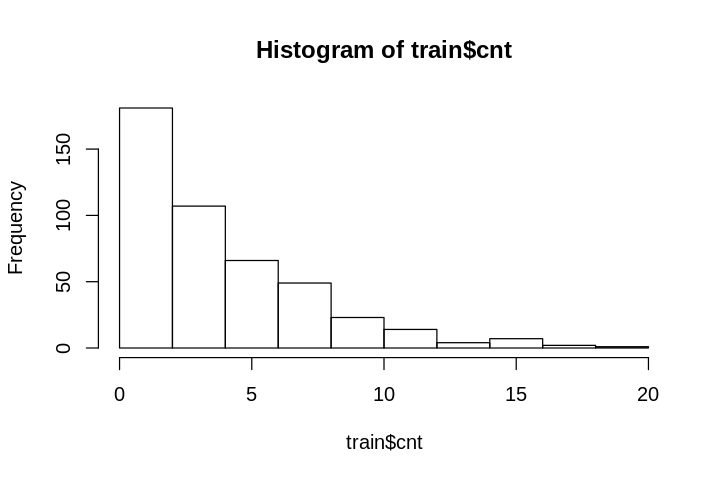

In [40]:
# here's what a histogram of the count variable looks like

hist(train$cnt)

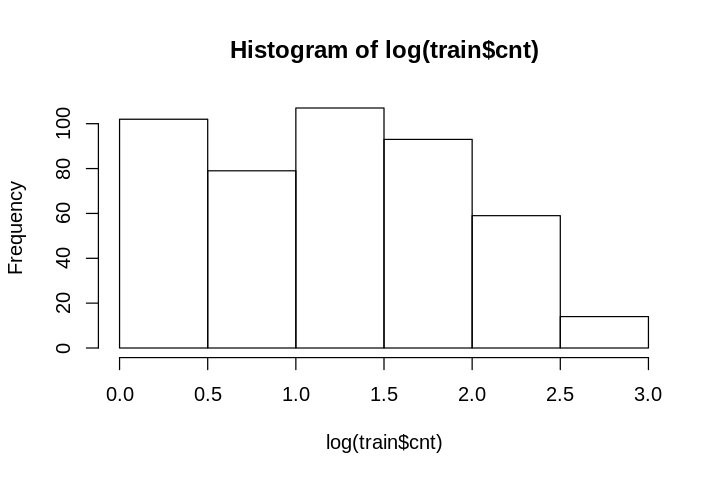

In [41]:
# here's the logarithm of this variable
hist(log(train$cnt))

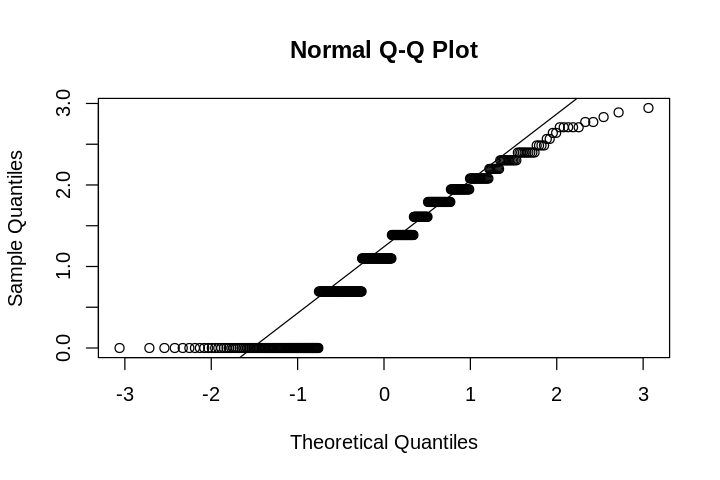

In [42]:
# does the logarithm of the count variable follow a normal distribution?
qqnorm(log(train$cnt))
qqline(log(train$cnt))

In [43]:
# normal linear regression of LIC_STATE, REGISTER_NAME and mon to predict logarithm of count

mod <- glm(data=train, log(cnt) ~ LIC_STATE + REGISTER_NAME + mon)
summary(mod)


Call:
glm(formula = log(cnt) ~ LIC_STATE + REGISTER_NAME + mon, data = train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.48110  -0.31032   0.00555   0.34417   1.30812  

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  0.11448    0.15468   0.740   0.4596    
LIC_STATENSW                 2.04474    0.13279  15.399  < 2e-16 ***
LIC_STATENT                 -0.07670    0.28825  -0.266   0.7903    
LIC_STATEQLD                 0.94734    0.13327   7.109 4.85e-12 ***
LIC_STATESA                  0.35795    0.14252   2.512   0.0124 *  
LIC_STATETAS                 0.08547    0.18421   0.464   0.6429    
LIC_STATEVIC                 1.46253    0.13279  11.014  < 2e-16 ***
LIC_STATEWA                  0.71225    0.13387   5.320 1.66e-07 ***
REGISTER_NAMECredit Licence -0.07416    0.04856  -1.527   0.1275    
mon02                       -0.20464    0.12373  -1.654   0.0989 .  
mon03                  

In [44]:
# YOUR TURN: drop mon as an explanatory variable 

head(train)

year,mon,REGISTER_NAME,LIC_STATE,cnt
<dbl>,<chr>,<chr>,<fct>,<int>
2012,01,AFS Licence,NSW,7
2012,01,AFS Licence,VIC,7
2012,01,Credit Licence,NSW,9
2012,01,Credit Licence,QLD,1
2012,01,Credit Licence,VIC,3
2012,01,Credit Licence,WA,3


In [45]:
# MY SOLUTION

mod <- glm(data=train, log(cnt) ~ LIC_STATE + REGISTER_NAME)
summary(mod)


Call:
glm(formula = log(cnt) ~ LIC_STATE + REGISTER_NAME, data = train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.53624  -0.32837  -0.02304   0.34655   1.36325  

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  0.10138    0.12221   0.830   0.4072    
LIC_STATENSW                 2.01707    0.13224  15.253  < 2e-16 ***
LIC_STATENT                 -0.02829    0.28591  -0.099   0.9212    
LIC_STATEQLD                 0.92014    0.13286   6.926 1.53e-11 ***
LIC_STATESA                  0.33689    0.14221   2.369   0.0183 *  
LIC_STATETAS                 0.04985    0.18406   0.271   0.7866    
LIC_STATEVIC                 1.43486    0.13224  10.850  < 2e-16 ***
LIC_STATEWA                  0.68790    0.13336   5.158 3.76e-07 ***
REGISTER_NAMECredit Licence -0.07309    0.04871  -1.500   0.1342    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaus

In [0]:
# now we predict our model from the training dataset onto the test dataset

test$pred <- predict(mod, newdata=test)
test$pred <- exp(test$pred)

In [47]:
head(test)

year,mon,REGISTER_NAME,LIC_STATE,cnt,pred
<dbl>,<chr>,<chr>,<fct>,<int>,<dbl>
2016,01,AFS Licence,ACT,1,1.106696
2016,01,AFS Licence,NSW,9,8.318214
2016,01,AFS Licence,QLD,5,2.777399
2016,01,AFS Licence,SA,1,1.550025
2016,01,AFS Licence,VIC,6,4.647064
2016,01,AFS Licence,WA,1,2.201797


In [0]:
# now we wish to change the structure of our test data from wide to long to make it easier to plot
test_dat <- gather(test, variable, value, cnt:pred)

In [49]:
head(test_dat)
tail(test_dat)

year,mon,REGISTER_NAME,LIC_STATE,variable,value
<dbl>,<chr>,<chr>,<fct>,<chr>,<dbl>
2016,01,AFS Licence,ACT,cnt,1
2016,01,AFS Licence,NSW,cnt,9
2016,01,AFS Licence,QLD,cnt,5
2016,01,AFS Licence,SA,cnt,1
2016,01,AFS Licence,VIC,cnt,6
2016,01,AFS Licence,WA,cnt,1


year,mon,REGISTER_NAME,LIC_STATE,variable,value
<dbl>,<chr>,<chr>,<fct>,<chr>,<dbl>
2018,12,AFS Licence,QLD,pred,2.777399
2018,12,AFS Licence,VIC,pred,4.647064
2018,12,AFS Licence,WA,pred,2.201797
2018,12,Credit Licence,NSW,pred,7.731944
2018,12,Credit Licence,QLD,pred,2.581647
2018,12,Credit Licence,VIC,pred,4.319537


## 6. Data product - web app actual vs expected in 2016 using data to 2015

In [0]:
ui <- fluidPage(
    titlePanel("Predicted 2016-2018 using data from 2012-2015"),
    sidebarLayout(
        sidebarPanel(
            selectInput(inputId = "subset_state", label = "Pick a state: ", 
                               choices = unique(test_dat$LIC_STATE))),
        mainPanel(plotOutput(outputId = "myfigure"))
    )
)


server <- function(input, output) {
    create_subset <- reactive(test_dat %>%
                                  filter(LIC_STATE == input$subset_state))
    
    output$myfigure <- renderPlot(
                            ggplot(create_subset()) +
                                      geom_bar(aes(x = year, y = value, fill=variable), stat="identity") + 
                                        facet_wrap(REGISTER_NAME ~ variable) +
                                        theme(axis.text.x = element_text(angle = 90, hjust = 1))
                                      
                            )
}


In [69]:
# Run app: this unfortunately won't work from Colab, but will run in RStudio :( 
# shinyApp(ui,server)


Listening on http://127.0.0.1:4962


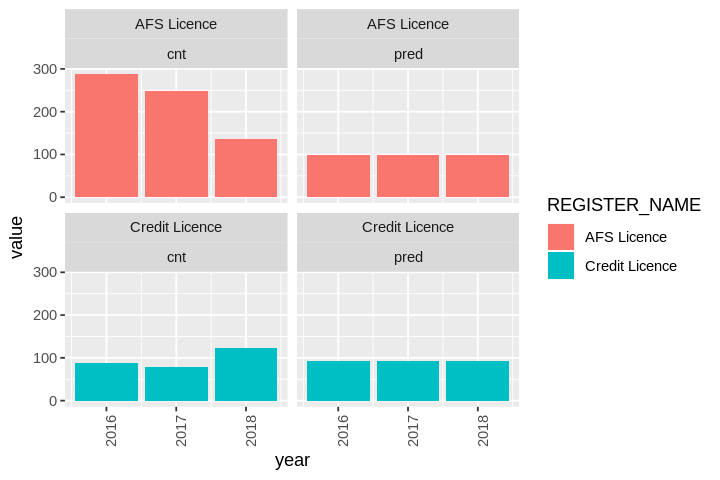

In [77]:
ggplot(test_dat[test_dat$LIC_STATE == 'NSW',]) + 
geom_bar(aes(x = year, y = value, fill=REGISTER_NAME), stat="identity") + 
                                        facet_wrap(REGISTER_NAME ~ variable) +
                                        theme(axis.text.x = element_text(angle = 90, hjust = 1))